In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch import optim
from gpytorch.kernels import RBFKernel, WhiteNoiseKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

## Training Data (1d Example)

In [3]:
n_samples = 20
train_x = torch.linspace(0, 1, n_samples)
train_y = (torch.sin(12*train_x.data) + 0.6*torch.cos(25*train_x.data) + torch.randn(n_samples)*0.2 + 3)



torch.Size([20]) torch.Size([20])


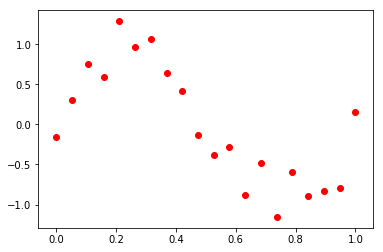

In [4]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 20)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
print(train_x.size(), train_y.size())
fig, ax = plt.subplots()

ax.scatter(train_x.data.numpy(), train_y.data.numpy(), color='r')
plt.show()

### Setup Model

In [5]:
class GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel() \
        + WhiteNoiseKernel(torch.ones(train_x.size(0)) * 0.01)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = GaussianLikelihood()
model = GPR(train_x.data.squeeze(), train_y.data.squeeze(), likelihood)

### Train Model

In [6]:
model.train()
likelihood.train()

# Optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Loss for GP 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss
training_iter = 50
for i in range(training_iter):
    
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # output of the model
    output = model(train_x)
#     print()
    # Calc loss 
    loss = -mll(output, train_y)
    
    # and backprop gradients
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale:    log_noise: %.3f' % (
    i + 1, training_iter, loss.data[0],
    model.likelihood.log_noise.data[0]
    ))
#     Step forward
    optimizer.step()

Iter 1/50 - Loss: 1.199   log_lengthscale:    log_noise: 0.000
Iter 2/50 - Loss: 1.164   log_lengthscale:    log_noise: -0.100
Iter 3/50 - Loss: 1.131   log_lengthscale:    log_noise: -0.199
Iter 4/50 - Loss: 1.099   log_lengthscale:    log_noise: -0.299
Iter 5/50 - Loss: 1.067   log_lengthscale:    log_noise: -0.399
Iter 6/50 - Loss: 1.036   log_lengthscale:    log_noise: -0.497
Iter 7/50 - Loss: 1.005   log_lengthscale:    log_noise: -0.596
Iter 8/50 - Loss: 0.971   log_lengthscale:    log_noise: -0.695
Iter 9/50 - Loss: 0.935   log_lengthscale:    log_noise: -0.793
Iter 10/50 - Loss: 0.897   log_lengthscale:    log_noise: -0.890
Iter 11/50 - Loss: 0.855   log_lengthscale:    log_noise: -0.987
Iter 12/50 - Loss: 0.811   log_lengthscale:    log_noise: -1.085
Iter 13/50 - Loss: 0.772   log_lengthscale:    log_noise: -1.183
Iter 14/50 - Loss: 0.738   log_lengthscale:    log_noise: -1.282
Iter 15/50 - Loss: 0.711   log_lengthscale:    log_noise: -1.382
Iter 16/50 - Loss: 0.686   log_leng

In [7]:
print(model.parameters)

<bound method Module.parameters of GPR(
  (likelihood): GaussianLikelihood()
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): RBFKernel()
      (1): WhiteNoiseKernel()
    )
  )
)>


### Predictions

In [8]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 51)

with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    

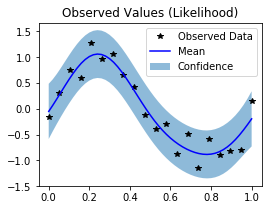

In [9]:
# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

### 2D Example

In [10]:
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [20]:
X, y = load_boston(return_X_y=True)
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / X.std()
xtrain, xtest, ytrain, ytest = \
    train_test_split(X, y, train_size=0.8, random_state=123)

/Users/eman/anaconda3/envs/gpytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
train_x = torch.Tensor(xtrain)
train_y = torch.Tensor(ytrain)
test_x = torch.Tensor(xtest)
test_y = torch.Tensor(ytest)

In [22]:
class GPRARD(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRARD, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(ard_num_dims=train_x.size(1)) \
        + WhiteNoiseKernel(torch.ones(train_x.size(0)) * 0.01)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = GaussianLikelihood()
model = GPR(train_x.data, train_y.data, likelihood)

In [23]:
# Initialize likelihood and model
likelihood = GaussianLikelihood()
model = GPRARD(train_x.data, train_y.data, likelihood)
print(model.parameters)

<bound method Module.parameters of GPRARD(
  (likelihood): GaussianLikelihood()
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): RBFKernel()
      (1): WhiteNoiseKernel()
    )
  )
)>


In [24]:
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Loss for GP 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss
training_iter = 200
for i in range(training_iter):
    
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # output of the model
    output = model(train_x)
    
    # Calc loss 
    loss = -mll(output, train_y)
    
    # and backprop gradients
    loss.backward()
    
#     Step forward
    optimizer.step()

In [25]:
print(model.parameters)

<bound method Module.parameters of GPRARD(
  (likelihood): GaussianLikelihood()
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): RBFKernel()
      (1): WhiteNoiseKernel()
    )
  )
)>


In [26]:
model.eval()
likelihood.eval()

with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    

In [27]:
mean = observed_pred.mean().data.numpy()

In [28]:
mse = mean_squared_error(mean, ytest)
mae = mean_absolute_error(mean, ytest)
r2 = r2_score(mean, ytest)
print(mse)
print(mae)
print(r2)

32.74937592229506
3.944720409080557
-0.061347128174602084


### Grid Interpolation kernel

In [29]:
print(train_x.min(), train_x.max())

tensor(-0.4827) tensor(4.4154)


In [31]:
# We use exact GP inference for regression# We us 
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel()
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=100,
                                                            grid_bounds=[(-1, 5)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', torch.nn.Parameter(torch.Tensor([0])))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [ ]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 30
for i in range(training_iterations):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.data[0]))
    optimizer.step()